# Figure 1 benchmarking

**Description:** Process data and prepare ready-to-use resources for plotting Figure 1 and Supplemental Figures 1-3

&rarr; Run this notebook with the `tf-train` kernel


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
import utilities
from utilities import preprocessing, sequence, model_builder, classification_cleavage, motifs, relative_strength, genomic_context, genetics


In [5]:
PROJECT = "/projects/b1080/eks/polyadenylation"
DATADIR = os.path.join(PROJECT, "manuscripts", "01_development", "data")
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_01")
os.makedirs(OUTDIR, exist_ok = True)


In [6]:
palette = {
    'PolyaID'         : '#5c9bd3',
    'PolyaStrength'   : '#adcce7',
    'DeepPASTA'       : '#ec7e30',
    'APARENT'         : '#a5a4a4',
    'APARENT2'        : '#fec010',
    'PolyApredictors' : '#4971b8',
}

## Benchmarking variant effect predictions

### Bogard et al 2019 MPRAs

In [7]:
with open(os.path.join(RESDIR, 'mpra_bogard.data.exp_clean.pickle'), mode = 'rb') as handle:
    mpra_bog = pickle.load(handle)
    
mpra_bog['max_a_fraction'] = mpra_bog['seq_ext'].apply(lambda x : classification_cleavage.calculate_a_density(x))
mpra_bog['observed_clvn']  = mpra_bog['observed_clvn'].apply(lambda x : np.asarray([float(_) for _ in x.strip("][").split(", ")]))

cond1 = (mpra_bog['library_name'] == 'HSPE1')
cond2 = (mpra_bog['max_a_fraction'] <= 0.75)
cond3 = (mpra_bog['our-models_classification'] >= 0.5)
cond4 = (mpra_bog['polyapredictors_expression'] != -99)
cond5 = (~mpra_bog['sequence'].str.contains("N"))

mpra_bog_filt = mpra_bog.loc[cond1 & cond2 & cond3 & cond4 & cond5].copy()

print(mpra_bog.shape)
print(mpra_bog_filt.shape)


(2512424, 28)
(337044, 28)


#### Split MPRA sequences into 5 groups based on expression

In [8]:
bins=[1,1.2,1.5,1.8,2,3]
labels = list(range(1,len(bins)))

mpra_bog_filt['expression_bin'], exp_bins = pd.cut(mpra_bog_filt['mpra_reads_log1p'], bins=bins, labels=labels, retbins = True)
print(mpra_bog_filt['expression_bin'].value_counts(sort = False))


1     25196
2     92845
3    133982
4     60339
5     24682
Name: expression_bin, dtype: int64


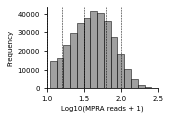

In [9]:
fig,ax = plt.subplots(1,1, figsize = (2,1.5))

sns.histplot(data = mpra_bog_filt, x = 'mpra_reads_log1p', color = 'gray', bins = 20, ax = ax)
for x in exp_bins: ax.axvline(x = x, color = 'black', linestyle = 'dashed', linewidth = 0.5)

ax.set_xlabel("Log10(MPRA reads + 1)")
ax.set_xlim(1,2.5)
ax.xaxis.set_major_locator(MultipleLocator(0.5))

ax.set_ylabel("Frequency")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'benchmark.bogard.histogram_expressionbins.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Plot corresponding predictions by expression group

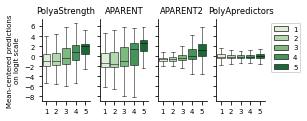

Wilcoxon rank-sum test:			statistic	p-val
our-models_strength                	 -122.624	0.000E+00
aparent_isoformAbundanceLO         	 -125.323	0.000E+00
aparent-resnet_isoformAbundanceLO  	 -133.499	0.000E+00
polyapredictors_expression         	   -1.065	2.867E-01


In [10]:
lo_cols  = [
    'our-models_strength',
    'aparent_isoformAbundanceLO',
    'aparent-resnet_isoformAbundanceLO',
    'polyapredictors_expression'
]

lo_labels = ['PolyaStrength','APARENT','APARENT2','PolyApredictors']
plot_data = mpra_bog_filt


fig,ax = plt.subplots(1,len(lo_cols), figsize = (4,1.5), sharex = True, sharey = True)

for i,(var,mod,a) in enumerate(zip(lo_cols,lo_labels,ax)):
    
    plot_data[f'{var}.rel_mean'] = plot_data[var] - plot_data[var].mean()

    sns.boxplot(data = plot_data, x = 'expression_bin', y = f'{var}.rel_mean', 
                hue = 'expression_bin', palette = 'Greens', dodge = False, 
                boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
                medianprops = {'color' : 'black', 'linewidth' : 0.5},
                whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
                capprops = {'color' : 'black', 'linewidth' : 0.5},
                flierprops = {'color' : 'black', 'markersize' : 1}, 
                showfliers = False, ax = a)
    
    a.set_xlabel("")
    a.set_ylabel("")
    a.set_title(mod)
    
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    
    if (i == len(lo_labels)-1):
        a.legend(bbox_to_anchor = (1.05,1))
    else:
        a.legend().remove()
    
ax[0].set_ylabel("Mean-centered predictions\non logit scale")
ax[0].yaxis.set_major_locator(MultipleLocator(2))

plt.savefig(os.path.join(OUTDIR, f'benchmark.bogard.predictions_by_expressionbins.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Wilcoxon rank-sum test:\t\t\tstatistic\tp-val")
dtL = plot_data.loc[plot_data['expression_bin'] == 1]
dtH = plot_data.loc[plot_data['expression_bin'] == 5]
for var in lo_cols:
    relvar = f'{var}.rel_mean'
    stres = st.ranksums(dtL[relvar],dtH[relvar])
    print(f"{var:35}\t{stres[0]:9.03f}\t{stres[1]:.03E}")


#### Classify the sites from groups 1 and 5

In [11]:
dt = mpra_bog_filt.loc[mpra_bog_filt['expression_bin'].isin([1,5])].copy()
dt['pseudoclass'] = mpra_bog_filt['expression_bin'].isin([5])
print(dt['pseudoclass'].value_counts())
print(f"Balance: {dt.pseudoclass.sum() / len(dt):.03%}")


False    25196
True     24682
Name: pseudoclass, dtype: int64
Balance: 49.485%


In [12]:
mpra_bog_aucs = pd.DataFrame(index = np.arange(len(lo_cols)), columns = ['model','sequences','auroc','auprc'])

dtH = mpra_bog_filt.loc[mpra_bog_filt['expression_bin'] == 5].copy()
dtH['pseudoclass'] = 1

dtL = mpra_bog_filt.loc[mpra_bog_filt['expression_bin'] == 1].copy()
dtL['pseudoclass'] = 0

dt = pd.concat([dtH,dtL], ignore_index = True, sort = False)


for i,(var,mod) in enumerate(zip(lo_cols, lo_labels)):
    auroc, auprc = classification_cleavage.calculate_auc(dt['pseudoclass'], dt[var])
    mpra_bog_aucs.loc[i] = [mod,len(dt),auroc,auprc]

print(dt.groupby('pseudoclass')['our-models_strength'].describe()[['count','mean','std']])


               count      mean       std
pseudoclass                             
0            25196.0 -3.451170  1.806507
1            24682.0 -1.335649  1.514889


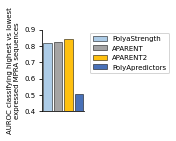

Corresponding metrics:
             model sequences     auroc     auprc
0    PolyaStrength     49878  0.817021  0.789277
1          APARENT     49878  0.823999   0.83934
2         APARENT2     49878  0.845135  0.844509
3  PolyApredictors     49878  0.502754  0.475355


In [13]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

sns.barplot(data = mpra_bog_aucs, x = 'model', y = 'auroc', 
            hue = 'model', hue_order = lo_labels, palette = palette, dodge = False,
            edgecolor = 'black', linewidth = 0.5, 
            saturation = 1, ax = ax)

ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlabel("")

ax.set_ylabel("AUROC classifying highest vs lowest\nexpressed MPRA sequences")
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.set_ylim(0.4,0.9)

ax.legend(bbox_to_anchor = (1.05,1))
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'benchmark.bogard.auroc_by_model.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding metrics:")
print(mpra_bog_aucs)


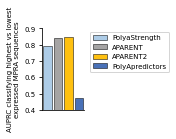

Corresponding metrics:
             model sequences     auroc     auprc
0    PolyaStrength     49878  0.817021  0.789277
1          APARENT     49878  0.823999   0.83934
2         APARENT2     49878  0.845135  0.844509
3  PolyApredictors     49878  0.502754  0.475355


In [14]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

sns.barplot(data = mpra_bog_aucs, x = 'model', y = 'auprc', 
            hue = 'model', hue_order = lo_labels, palette = palette, dodge = False,
            edgecolor = 'black', linewidth = 0.5, 
            saturation = 1, ax = ax)

ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlabel("")

ax.set_ylabel("AUPRC classifying highest vs lowest\nexpressed MPRA sequences")
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.set_ylim(0.4,0.9)

ax.legend(bbox_to_anchor = (1.05,1))
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'benchmark.bogard.auprc_by_model.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding metrics:")
print(mpra_bog_aucs)
